In [1]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fgsm.deep_convnet import DeepConvNet
from common.functions import softmax

import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
num_classes = 10

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_test.shape (10000, 28, 28)
y_test.shape (10000,)


In [4]:
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255

y_test1 = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# モデルを読み込む
model = model_from_json(open('mnist_mlp_model_few.json').read())

# 学習結果を読み込む
model.load_weights('mnist_mlp_weights_few.h5')

model.summary();

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
____________________________________________________________

In [6]:
score = model.evaluate(X_test.reshape(X_test.shape[0], 784), y_test1, verbose=0)
# print('Test loss :', score[0])
print('kerasの正答率：', score[1])

kerasの正答率： 0.9778


In [7]:
network = DeepConvNet()

network.load_params("keras_clone_params_few.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [8]:
test_acc = network.accuracy(X_test, y_test)
print("クローンの正答率：", test_acc)

クローンの正答率： 0.8055


In [9]:
def generate_adv(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [10]:
def change_adv_list(x_list, t_list, network, eps):
    adv_list = []
    for x, t in zip(x_list, t_list):
        adv = generate_adv(x, t, network, eps)
        adv_list.append(adv.reshape(1, 28, 28))
        
    adv_list = np.array(adv_list)
    return adv_list

In [15]:
fgsm_test = change_adv_list(X_test, y_test, network, 0.3)
fgsm_test.shape

(10000, 1, 28, 28)

In [16]:
fgsm_acc = network.accuracy(fgsm_test, y_test)
print("FGSMに対するクローンの正答率：", fgsm_acc)

FGSMに対するクローンの正答率： 0.3212


In [17]:
FGSM_test = fgsm_test.reshape(fgsm_test.shape[0], 784)
fgsm_score = model.evaluate(FGSM_test, y_test1, verbose=0)
# print('Test loss :', score[0])
print('FGSMに対するkerasの正答率：', fgsm_score[1])

FGSMに対するkerasの正答率： 0.6389


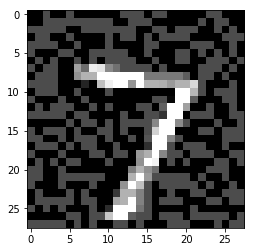

In [18]:
plt.imshow(fgsm_test[0].reshape(28,28), 'gray')
plt.show()